In [2]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, Iterator, Tuple

import h5py
import numpy as np
import pandas as pd


@dataclass
class CapacitorStressMat:
    """
    NASA 『Capacitor Electrical Stress』 MAT ファイルローダー。

    - ES10.mat / ES12.mat / ES14.mat に対応（file_name で切り替え）
    - Transient_Data（VO / VL / Serial_Date）
    - EIS_Data（そのまま numpy で返す）

    ✅ このクラスは「生データを取り出す専用」
       → 劣化解析や特徴量抽出は別ノートでゆっくりやる感じで。
    """

    data_dir: Path = Path("./12.CapacitorElectricalStress")
    file_name: str = "ES10.mat"
    transient_root: str = "ES10/Transient_Data"
    eis_root: str = "ES10/EIS_Data"

    def __post_init__(self) -> None:
        self.data_dir = Path(self.data_dir)
        self.path: Path = self.data_dir / self.file_name
        if not self.path.exists():
            raise FileNotFoundError(f"MAT file not found: {self.path}")

        # HDF5 としてオープン
        self._h5: h5py.File = h5py.File(str(self.path), "r")

        # ファイル名から ES10 / ES12 / ES14 を推定してパスを自動調整
        # （手で transient_root / eis_root を上書きしてもOK）
        root_name = self.file_name.split(".")[0]  # "ES10"
        self.transient_root = f"{root_name}/Transient_Data"
        self.eis_root = f"{root_name}/EIS_Data"

    # ---- context manager 対応 -------------------------------------------------

    def close(self) -> None:
        if self._h5 is not None and self._h5.id:
            self._h5.close()

    def __enter__(self) -> "CapacitorStressMat":
        return self

    def __exit__(self, exc_type, exc, tb) -> None:
        self.close()

    # ---- 構造確認系 -----------------------------------------------------------

    @property
    def h5(self) -> h5py.File:
        """h5py.File をそのまま触りたいとき用のアクセサ。"""
        return self._h5

    def list_top_keys(self) -> Iterable[str]:
        """MAT ファイル直下のキー一覧（'ES10', '#refs#' など）"""
        return list(self._h5.keys())

    def list_capacitors(self) -> Iterable[str]:
        """
        Transient_Data 配下にぶら下がっている個体名を列挙。
        例: ['ES10C1', 'ES10C2', ..., 'ES10C7']
        """
        grp = self._h5[self.transient_root]
        return [k for k, v in grp.items() if isinstance(v, h5py.Group)]

    # ---- Transient (VO / VL / Serial_Date) 系 ---------------------------------

    def get_serial_date(self) -> np.ndarray:
        """
        Serial_Date を numpy で返す。
        shape はデータそのまま（例: (N,) or (N, M)）。
        """
        ds = self._h5[f"{self.transient_root}/Serial_Date"]
        return np.array(ds)

    def get_transient_matrix(
        self, cap_name: str
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        指定個体（例: 'ES10C7'）の Transient データをまとめて取得。

        Returns
        -------
        time : np.ndarray
            Serial_Date。shape は VO/VL と同じか 1次元。
        vo : np.ndarray
            VO データ。ふつうは (n_samples, n_shots) みたいな2次元。
        vl : np.ndarray
            VL データ。同上。
        """
        base = f"{self.transient_root}/{cap_name}"
        time = self.get_serial_date()
        vo = np.array(self._h5[f"{base}/VO"])
        vl = np.array(self._h5[f"{base}/VL"])
        return time, vo, vl

    def iter_shots(
        self, cap_name: str
    ) -> Iterator[Tuple[int, np.ndarray, np.ndarray, np.ndarray]]:
        """
        1ショット（1列）ずつ VO/VL を取り出すイテレータ。

        Yields
        ------
        shot_idx : int
            ショット番号（列インデックス）。
        time_1d : np.ndarray
            そのショットの時間軸。time が 2次元なら該当列、
            1次元ならそのまま。
        vo_1d : np.ndarray
            そのショットの VO 波形（NaN 含む場合あり）。
        vl_1d : np.ndarray
            そのショットの VL 波形。
        """
        time, vo, vl = self.get_transient_matrix(cap_name)

        vo = np.asarray(vo)
        vl = np.asarray(vl)

        if vo.ndim == 1:
            # そもそもショット分割されてない場合はそのまま 1 ショット扱い
            t = np.asarray(time).ravel()
            yield 0, t, vo, vl
            return

        n_samples, n_shots = vo.shape

        # time が (n_samples,) か (n_samples, n_shots) のどちらにも対応
        time_arr = np.asarray(time)
        if time_arr.shape == (n_samples,):
            # 全ショット共通の時間軸
            base_time = time_arr
            for j in range(n_shots):
                yield j, base_time, vo[:, j], vl[:, j]
        elif time_arr.shape == (n_samples, n_shots):
            for j in range(n_shots):
                yield j, time_arr[:, j], vo[:, j], vl[:, j]
        else:
            # よくわからん形のときは、とりあえず一次元にして返す
            base_time = time_arr.reshape(-1)
            for j in range(n_shots):
                yield j, base_time, vo[:, j], vl[:, j]

    def get_transient_long_df(self, cap_name: str) -> pd.DataFrame:
        """
        1個体の全ショットを「縦持ち DataFrame」で返すユーティリティ。

        Columns:
            - 'shot_idx'
            - 'sample_idx'
            - 'timestamp'
            - 'VO'
            - 'VL'
        """
        time, vo, vl = self.get_transient_matrix(cap_name)
        vo = np.asarray(vo)
        vl = np.asarray(vl)

        if vo.ndim == 1:
            # ショット1本だけ
            t = np.asarray(time).ravel()
            n = vo.size
            return pd.DataFrame(
                {
                    "shot_idx": np.zeros(n, dtype=int),
                    "sample_idx": np.arange(n, dtype=int),
                    "timestamp": t,
                    "VO": vo,
                    "VL": vl,
                }
            )

        n_samples, n_shots = vo.shape
        time_arr = np.asarray(time)

        if time_arr.shape == (n_samples,):
            # 共通時間軸
            t = np.tile(time_arr.reshape(-1, 1), (1, n_shots))
        elif time_arr.shape == (n_samples, n_shots):
            t = time_arr
        else:
            t = np.tile(time_arr.reshape(-1, 1), (1, n_shots))

        df = pd.DataFrame(
            {
                "shot_idx": np.repeat(np.arange(n_shots), n_samples),
                "sample_idx": np.tile(np.arange(n_samples), n_shots),
                "timestamp": t.reshape(-1),
                "VO": vo.reshape(-1),
                "VL": vl.reshape(-1),
            }
        )
        return df

    # ---- EIS 系 ---------------------------------------------------------------

    def get_eis_group(self, cap_name: str) -> h5py.Group:
        """
        EIS_Data の Group をそのまま返す。
        何が入ってるかは `list_eis_datasets()` で確認。
        """
        return self._h5[f"{self.eis_root}/{cap_name}"]

    def list_eis_datasets(self, cap_name: str) -> Dict[str, Tuple[int, ...]]:
        """
        EIS_Data/{cap} 配下の Dataset 一覧と shape を dict で返す。
        例:
            {'Frequency': (N,),
             'Z_real': (N, M),
             'Z_imag': (N, M)}
        """
        grp = self.get_eis_group(cap_name)
        info = {}
        for k, v in grp.items():
            if isinstance(v, h5py.Dataset):
                info[k] = tuple(v.shape)
        return info

    def get_eis_raw(self, cap_name: str) -> Dict[str, np.ndarray]:
        """
        EIS_Data/{cap} の全 Dataset を numpy 化して dict で返す。
        """
        grp = self.get_eis_group(cap_name)
        out: Dict[str, np.ndarray] = {}
        for k, v in grp.items():
            if isinstance(v, h5py.Dataset):
                out[k] = np.array(v)
        return out


In [73]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


@dataclass
class CapacitorVisualizer:
    """
    CapacitorStressMat で読んだデータを可視化するクラス。

    - 1 個体ごとの v_max / v_min / peak_to_peak / rms を計算
    - 4 段プロットで劣化傾向を確認

    例:
        ds = CapacitorStressMat(...)
        viz = CapacitorVisualizer(ds)
        df = viz.compute_transient_features("ES10C7")
        viz.plot_transient_features("ES10C7")
    """

    dataset: "CapacitorStressMat"

    # ---------------------------------------------------------
    # 内部ユーティリティ
    # ---------------------------------------------------------
    def _compute_features_for_cap(
        self,
        cap_name: str,
        use_vo: bool = True,
    ) -> pd.DataFrame:
        """
        1 個体の全ショットについて、基本統計量を計算する。

        Parameters
        ----------
        cap_name : str
            例: "ES10C7"
        use_vo : bool
            True のとき VO、False のとき VL から特徴量を作る。

        Returns
        -------
        DataFrame with columns:
            - idx           : shot index
            - v_max, v_min
            - peak_to_peak
            - rms
        """
        rows = []
        for shot_idx, t, vo, vl in self.dataset.iter_shots(cap_name):
            sig = np.asarray(vo if use_vo else vl, float)
            sig = sig[~np.isnan(sig)]
            if sig.size == 0:
                continue

            v_max = sig.max()
            v_min = sig.min()
            peak_to_peak = v_max - v_min
            rms = float(np.sqrt(np.mean(sig**2)))

            rows.append(
                dict(
                    idx=shot_idx,
                    v_max=float(v_max),
                    v_min=float(v_min),
                    peak_to_peak=float(peak_to_peak),
                    rms=rms,
                )
            )

        df = pd.DataFrame(rows).sort_values("idx").reset_index(drop=True)
        return df

    # ---------------------------------------------------------
    # 公開 API
    # ---------------------------------------------------------
    def compute_transient_features(
        self,
        cap_name: str,
        use_vo: bool = True,
    ) -> pd.DataFrame:
        """
        外から呼ぶ用のラッパ。計算した特徴量 DataFrame を返す。
        """
        return self._compute_features_for_cap(cap_name, use_vo=use_vo)

    def plot_transient_features(
        self,
        cap_name: str,
        use_vo: bool = True,
        figsize: Tuple[float, float] = (12, 8),
        title: Optional[str] = None,
    ) -> pd.DataFrame:
        """
        さっきの 4 段プロットを描くメソッド。

        Parameters
        ----------
        cap_name : str
            例: "ES10C7"
        use_vo : bool
            True: VO ベース, False: VL ベース
        figsize : tuple
            プロットサイズ
        title : str or None
            図全体のタイトル。None なら自動生成。

        Returns
        -------
        feature_df : pd.DataFrame
            プロットに使った特徴量 DataFrame。
        """
        feature_df = self._compute_features_for_cap(cap_name, use_vo=use_vo)
        x = feature_df["idx"]

        fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)

        sig_label = "VO" if use_vo else "VL"

        # v_max
        axes[0].plot(x, feature_df["v_max"], label="v_max")
        axes[0].set_ylabel("v_max [V]")
        axes[0].grid(True)
        axes[0].legend()

        # v_min
        axes[1].plot(x, feature_df["v_min"], label="v_min", color="tab:orange")
        axes[1].set_ylabel("v_min [V]")
        axes[1].grid(True)
        axes[1].legend()

        # peak-to-peak
        axes[2].plot(
            x,
            feature_df["peak_to_peak"],
            label="peak_to_peak",
            color="tab:green",
        )
        axes[2].set_ylabel("peak-to-peak [V]")
        axes[2].grid(True)
        axes[2].legend()

        # rms
        axes[3].plot(x, feature_df["rms"], label="rms", color="tab:red")
        axes[3].set_ylabel("rms [V]")
        axes[3].set_xlabel("shot idx")
        axes[3].grid(True)
        axes[3].legend()

        if title is None:
            title = f"{cap_name} transient features ({sig_label})"
        fig.suptitle(title, y=1.02)

        plt.tight_layout()
        plt.show()

        return feature_df

    def plot_overlaid_waveforms(
        self,
        cap_name: str,
        shot_indices: list[int] | None = None,
        use_vo: bool = True,
        figsize=(12, 5),
        normalize_time: bool = True,
        alpha: float = 0.4,
    ):
        """
        同一個体の複数ショット波形を重ね描きする可視化。

        Parameters
        ----------
        cap_name : str
            例: "ES10C7"
        shot_indices : list[int] | None
            None の場合 → 全ショットの中から
            [最初, 25%, 50%, 75%, 最後] を自動抽出
        use_vo : bool
            True なら VO, False なら VL を使用
        normalize_time : bool
            True → 最初のサンプルを 0 に揃える
        alpha : float
            透明度（0〜1）
        """
        # すべてのショットを一旦リスト化
        shots = list(self.dataset.iter_shots(cap_name))
        total = len(shots)
        if total == 0:
            raise ValueError(f"No shots found for {cap_name}")

        # 自動ショット選択
        if shot_indices is None:
            shot_indices = sorted(
                set([0, total // 4, total // 2, (total * 3) // 4, total - 1])
            )

        plt.figure(figsize=figsize)
        label = "VO" if use_vo else "VL"

        skipped = 0

        for idx in shot_indices:
            if idx < 0 or idx >= total:
                print(f"[WARN] shot index {idx} out of range (0..{total-1}), skip")
                continue

            shot_idx, t, vo, vl = shots[idx]
            sig = np.asarray(vo if use_vo else vl, float)

            # NaN を除去
            mask = ~np.isnan(sig)
            sig = sig[mask]
            t = np.asarray(t)[mask]

            # 有効サンプルがなければスキップ
            if sig.size == 0:
                skipped += 1
                continue

            if normalize_time:
                t = t - t[0]

            plt.plot(t, sig, alpha=alpha, label=f"shot {shot_idx}")

        if skipped > 0:
            print(f"[INFO] skipped {skipped} empty shots (all-NaN after masking)")

        plt.xlabel("time (normalized)" if normalize_time else "raw timestamp")
        plt.ylabel(f"{label} [V]")
        plt.title(f"Overlaid waveforms: {cap_name} ({label})")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_overlaid_high_region(
        self,
        cap_name: str,
        shot_indices: list[int] | None = None,
        use_vo: bool = True,
        v_threshold: float = 8.0,
        max_points: int = 2000,
        figsize=(12, 5),
        alpha: float = 0.5,
    ):
        """
        VO(またはVL) が v_threshold 以上の区間だけを抜き出して重ね描き。

        - 高電圧側のリップルや droop の違いを見たいとき用。
        """
        shots = list(self.dataset.iter_shots(cap_name))
        total = len(shots)
        if total == 0:
            raise ValueError(f"No shots found for {cap_name}")

        if shot_indices is None:
            shot_indices = sorted(
                set([0, total // 4, total // 2, (total * 3) // 4, total - 1])
            )

        plt.figure(figsize=figsize)
        label = "VO" if use_vo else "VL"
        skipped = 0

        for idx in shot_indices:
            if not (0 <= idx < total):
                continue
            shot_idx, t, vo, vl = shots[idx]
            sig_all = np.asarray(vo if use_vo else vl, float)
            t_all = np.asarray(t, float)

            mask_valid = (~np.isnan(sig_all)) & (sig_all >= v_threshold)
            sig = sig_all[mask_valid]
            tt = t_all[mask_valid]

            if sig.size == 0:
                skipped += 1
                continue

            # 時間を0基準に
            tt = tt - tt[0]

            # ポイント多すぎるときは間引き
            if sig.size > max_points:
                step = sig.size // max_points
                sig = sig[::step]
                tt = tt[::step]

            plt.plot(tt, sig, alpha=alpha, label=f"shot {shot_idx}")

        if skipped:
            print(f"[INFO] skipped {skipped} shots (no samples above {v_threshold} V)")

        plt.xlabel("time (normalized, high region)")
        plt.ylabel(f"{label} [V]")
        plt.title(f"Overlaid high-voltage region: {cap_name} ({label})")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_folded_transient_features(
        self,
        cap_name: str,
        cycle_length: int,
        use_vo: bool = True,
        max_cycles: int | None = None,
        step_cycles: int = 1,
        figsize=(12, 8),
        phase_range: tuple[int, int] | None = None,  # ★追加
    ) -> pd.DataFrame:
        """
        plot_transient_features() の結果を「サイクル長」で折りたたんで、
        1サイクル分のトレースを複数サイクル重ねて描画する。

        phase_range が指定されていれば、その phase 範囲だけに絞って表示。
        """
        df = self.compute_transient_features(cap_name, use_vo=use_vo).copy()
        if df.empty:
            raise ValueError("feature_df is empty")

        # サイクル / 位相を付与
        df["cycle"] = df["idx"] // cycle_length
        df["phase"] = df["idx"] % cycle_length

        # ★ phaseで窓を切る
        if phase_range is not None:
            p0, p1 = phase_range
            df = df[(df["phase"] >= p0) & (df["phase"] <= p1)]

        n_cycles = int(df["cycle"].max()) + 1
        if max_cycles is not None:
            n_cycles = min(n_cycles, max_cycles)

        fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
        features = ["v_max", "v_min", "peak_to_peak", "rms"]
        colors = plt.cm.viridis(
            np.linspace(0, 1, max(1, n_cycles // step_cycles + 1))
        )

        for ci, cycle_idx in enumerate(range(0, n_cycles, step_cycles)):
            sub = df[df["cycle"] == cycle_idx]
            if sub.empty:
                continue
            x = sub["phase"]

            for ax, feat in zip(axes, features):
                ax.plot(
                    x,
                    sub[feat],
                    color=colors[ci],
                    alpha=0.6,
                    label=f"cycle {cycle_idx}" if feat == "v_max" else None,
                )

        axes[0].set_ylabel("v_max [V]")
        axes[1].set_ylabel("v_min [V]")
        axes[2].set_ylabel("peak-to-peak [V]")
        axes[3].set_ylabel("rms [V]")
        axes[3].set_xlabel("phase within cycle (shot index in cycle)")

        for ax in axes:
            ax.grid(True)

        axes[0].legend(title="cycle", bbox_to_anchor=(1.02, 1), loc="upper left")

        sig_label = "VO" if use_vo else "VL"
        fig.suptitle(
            f"Folded transient features for {cap_name} ({sig_label})\n"
            f"(cycle_length={cycle_length}, phase_range={phase_range})",
            y=1.02,
        )
        plt.tight_layout()
        plt.show()

        return df

    def plot_resampled_cycles(
        self,
        cap_name: str,
        cycles: list[tuple[int, int]],
        use_vo: bool = True,
        base_length: int | None = None,
        figsize=(12, 8),
    ):
        """
        指定した idx 範囲の各サイクルを「時間正規化して」
        共通の横軸（base_length）上にリサンプルし、重ね描きする。

        例: ES10C7 の場合
            cycles = [(0, 199), (200, 389)]
            → 各200ポイントのトレースを 390ポイント軸に引き伸ばして
              v_max / v_min / p2p / rms を CycleLength=400 相当の軸で比較。

        Parameters
        ----------
        cap_name : str
            例: "ES10C7"
        cycles : list of (start_idx, end_idx)
            df["idx"] の範囲で 1サイクルを指定。
        use_vo : bool
            True: VO ベース（compute_transient_features と同じ）
        base_length : int | None
            共通のサンプル数。None のときは df 全体の長さを使う。
            → ES10C7 なら 390。
        """
        import numpy as np
        import matplotlib.pyplot as plt

        df = self.compute_transient_features(cap_name, use_vo=use_vo).copy()
        if df.empty:
            raise ValueError("feature_df is empty")

        if base_length is None:
            base_length = len(df)

        x_ref = np.arange(base_length)  # 0..base_length-1 を共通軸にする
        features = ["v_max", "v_min", "peak_to_peak", "rms"]

        fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
        cmap = plt.cm.plasma
        colors = cmap(np.linspace(0, 1, len(cycles)))

        for ci, (start_idx, end_idx) in enumerate(cycles):
            sub = df[(df["idx"] >= start_idx) & (df["idx"] <= end_idx)].copy()
            if sub.empty:
                continue

            # ローカル軸（0..1）に正規化
            n_points = len(sub)
            local_x = np.linspace(0.0, 1.0, n_points)

            # 共通軸(0..base_length-1)側の位置
            target_x = np.linspace(0.0, 1.0, base_length)

            color = colors[ci]
            label = f"cycle {ci} [{start_idx}-{end_idx}]"

            for ax, feat in zip(axes, features):
                y = sub[feat].values.astype(float)
                # 線形補間で共通軸にリサンプル
                y_resampled = np.interp(target_x, local_x, y)
                ax.plot(x_ref, y_resampled, color=color, alpha=0.8,
                        label=label if feat == "v_max" else None)

        axes[0].set_ylabel("v_max [V]")
        axes[1].set_ylabel("v_min [V]")
        axes[2].set_ylabel("peak-to-peak [V]")
        axes[3].set_ylabel("rms [V]")
        axes[3].set_xlabel("virtual idx (aligned to full 400-shot axis)")

        for ax in axes:
            ax.grid(True)

        axes[0].legend(title="resampled cycles",
                       bbox_to_anchor=(1.02, 1), loc="upper left")

        sig_label = "VO" if use_vo else "VL"
        fig.suptitle(
            f"Resampled cycles for {cap_name} ({sig_label})\n"
            f"cycles={cycles}, base_length={base_length}",
            y=1.02,
        )
        plt.tight_layout()
        plt.show()

    def plot_shot_waveform_pair(
        self,
        cap_name: str,
        shot_a: int,
        shot_b: int,
        use_vo: bool = True,
        normalize_time: bool = True,
        normalize_amp: bool = False,
        figsize=(12, 4),
    ):
        """
        同一個体の「あるショット」と「別のショット」の波形を重ねて比較する。

        例:
            viz.plot_shot_waveform_pair("ES10C7", shot_a=0, shot_b=200)
            → 劣化前(0回目付近)と、かなり劣化した時(200回目付近)を比較
        """
        import numpy as np
        import matplotlib.pyplot as plt

        shots = list(self.dataset.iter_shots(cap_name))
        n = len(shots)
        if not (0 <= shot_a < n and 0 <= shot_b < n):
            raise ValueError(f"shot index out of range (0..{n-1})")

        def _get(sig_idx):
            shot_idx, t, vo, vl = shots[sig_idx]
            sig = np.asarray(vo if use_vo else vl, float)
            t = np.asarray(t, float)
            mask = ~np.isnan(sig)
            sig = sig[mask]
            t = t[mask]
            if normalize_time:
                t = t - t[0]
            if normalize_amp:
                # 最大値で正規化して形だけ比較したい時用
                m = np.nanmax(np.abs(sig))
                if m > 0:
                    sig = sig / m
            return t, sig

        t_a, y_a = _get(shot_a)
        t_b, y_b = _get(shot_b)

        plt.figure(figsize=figsize)
        label = "VO" if use_vo else "VL"
        plt.plot(t_a, y_a, label=f"shot {shot_a}", alpha=0.8)
        plt.plot(t_b, y_b, label=f"shot {shot_b}", alpha=0.8)
        plt.xlabel("time (normalized)" if normalize_time else "time")
        plt.ylabel(f"{label} [V]" if not normalize_amp else f"{label} (norm.)")
        plt.title(f"{cap_name}: waveform comparison ({label})")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


In [65]:
from pathlib import Path

ds = CapacitorStressMat(
    data_dir=Path("./12.CapacitorElectricalStress"),
    file_name="ES10.mat",
)

In [75]:
viz = CapacitorVisualizer(ds)

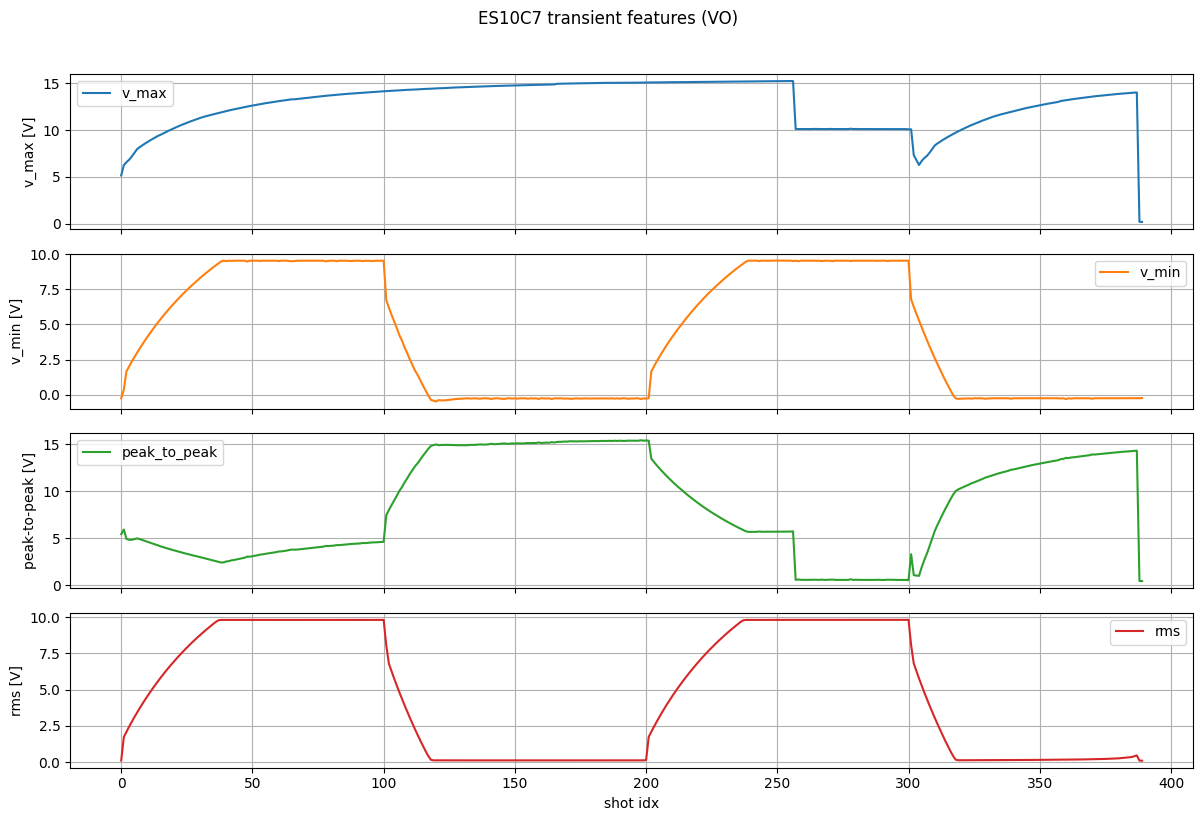

In [71]:
feature_df = viz.plot_transient_features("ES10C7", use_vo=True)

In [68]:
df_raw = viz.compute_transient_features("ES10C7")
print(len(df_raw))
print(df_raw[["idx"]].head())
print(df_raw[["idx"]].tail())


390
   idx
0    0
1    1
2    2
3    3
4    4
     idx
385  385
386  386
387  387
388  388
389  389


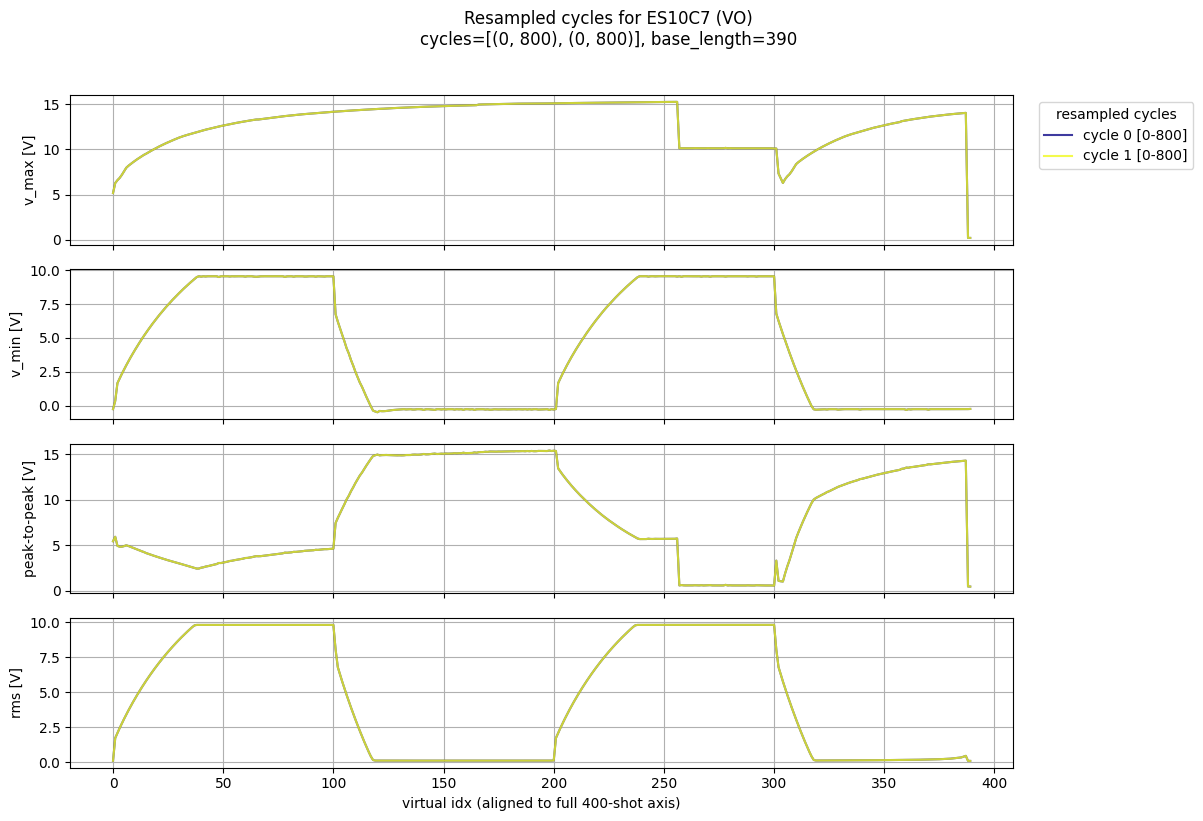

In [61]:
# df_raw の長さは 390 だったので base_length は 390 のまま
viz.plot_resampled_cycles(
    "ES10C7",
    cycles=[(0, 800), (0, 800)],
    use_vo=True,
    base_length=390,   # 省略してもOK（自動で len(df) になる）
)

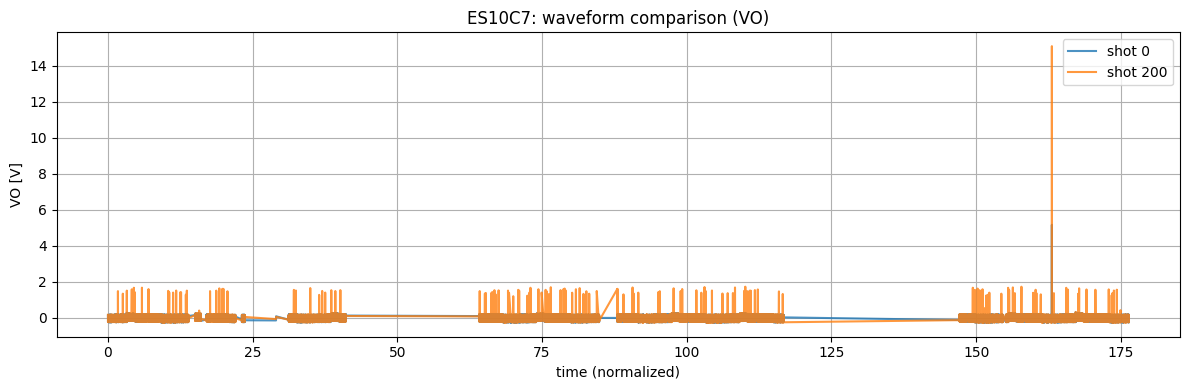

In [76]:
viz.plot_shot_waveform_pair("ES10C7", 0, 200)